# Classical ML Text Classification Pipeline


## Overview
This notebook implements the classical ML component of our multimodal ensemble:
1. **Section 1**: Comprehensive model selection (run once for experimentation)
2. **Section 2**: Production model training (optimized for ensemble integration)

**Why two sections?**
- **Development vs Production**: Section 1 documents the experimental process for academic presentation, while Section 2 provides clean, deployment-ready code
- **Computational Efficiency**: Section 1 is expensive (grid search across 4 algorithms), Section 2 is fast (33 minutes) for iterative development
- **Ensemble Requirements**: Section 2 ensures `probability=True` for soft voting integration with BERT and VGG16 models

**Note**: Section 1 contains computationally expensive grid search. For regular use, run Section 2 only.

## 1. Model Selection & Hyperparameter Tuning

*Purpose: Compare 4 algorithms (LogReg, SVM, RF, XGBoost) to find best performer*
- Grid search with cross-validation
- Identifies optimal hyperparameters
- **Result: SVM with TfidfVectorizer achieves best F1 score (0.76)**

### 1.1 Loading the Libraries & Data Exploration

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime


In [4]:
# Load the CSV file into a DataFrame
df_localization = pd.read_csv('../data/language_analysis/df_localization.csv')

# Display the first rows of the DataFrame
print(df_localization.head())

    productid     imageid  prdtypecode  bool_description  \
0  3804725264  1263597046           10                 0   
1   436067568  1008141237         2280                 0   
2   201115110   938777978           50                 1   
3    50418756   457047496         1280                 0   
4   278535884  1077757786         2705                 1   

                                         merged_text lang  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   de   
1  Journal Des Arts Le N° 133 Du 28/09/2001 - L'a...   fr   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   fr   
3  Peluche Donald - Europe - Disneyland 2000 Mari...   fr   
4  La Guerre Des Tuques - Luc a des idées de gran...   fr   

                                   deepL_translation  
0  Olivia : Carnet de notes personnalisé / 150 pa...  
1                                                NaN  
2                                                NaN  
3                                                NaN

### 1.2 Data Preprocessing

In [5]:
# Download the stopwords list
nltk.download('stopwords')

# Get the French stop words
french_stop_words = set(stopwords.words('french'))

# Function to preprocess text: lowercase, remove punctuation, and remove stop words
def preprocess_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    text = text.lower()  # Convert to lowercase, because stopwords are case-sensitive
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in french_stop_words])  # Remove stop words
    return text

# Create a new DataFrame with the "text" column
df_processed = df_localization.copy()
df_processed['text'] = df_processed.apply(
    lambda row: preprocess_text(row['deepL_translation']) if pd.notna(row['deepL_translation']) else preprocess_text(row['merged_text']),
    axis=1
)

# Retain only the "text" and "prdtypecode" columns
df_processed = df_processed[['text', 'prdtypecode']]

# Display the first rows of the new DataFrame
print(df_processed.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertwilson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  prdtypecode
0  olivia carnet notes personnalisé 150 pages gri...           10
1  journal arts n° 133 28092001 lart marche salon...         2280
2  pilot style touch pen marque speedlink 1 style...           50
3  peluche donald europe disneyland 2000 marionne...         1280
4  guerre tuques luc a idées grandeur veut organi...         2705


### 1.4 Check df for correct size

In [6]:
# Print the shape of the new DataFrame
print(df_processed.shape)

(84916, 2)


### 1.5 Data Splits: Feature & Target Data, Train & Test Data

### Stratified Split

In [ ]:
# Define feature (X) and target (y) variables
X = df_processed['text']  # Feature: text column
y = df_processed['prdtypecode']  # Target: prdtypecode column

# Initialize stratified shuffle split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

from collections import Counter
import numpy as np

def print_class_distribution(y, dataset_name):
    # Count the occurrences of each class
    class_counts = Counter(y)
    total_samples = sum(class_counts.values())
    
    # Calculate the relative distribution in percentages
    relative_distribution = {cls: (count / total_samples) * 100 for cls, count in class_counts.items()}
    
    # Print the distribution
    print(f"Class distribution in {dataset_name} (in %):")
    for cls, percentage in sorted(relative_distribution.items()):
        print(f"  Class {cls}: {percentage:.2f}%")
    print()

# Print the relative class distributions
print_class_distribution(y, "Original Dataset")
print_class_distribution(y_train, "Training Set")
print_class_distribution(y_test, "Test Set")

Class distribution in Original Dataset (in %):
  Class 10: 3.67%
  Class 40: 2.95%
  Class 50: 1.98%
  Class 60: 0.98%
  Class 1140: 3.15%
  Class 1160: 4.66%
  Class 1180: 0.90%
  Class 1280: 5.74%
  Class 1281: 2.44%
  Class 1300: 5.94%
  Class 1301: 0.95%
  Class 1302: 2.93%
  Class 1320: 3.82%
  Class 1560: 5.97%
  Class 1920: 5.07%
  Class 1940: 0.95%
  Class 2060: 5.88%
  Class 2220: 0.97%
  Class 2280: 5.61%
  Class 2403: 5.62%
  Class 2462: 1.67%
  Class 2522: 5.88%
  Class 2582: 3.05%
  Class 2583: 12.02%
  Class 2585: 2.94%
  Class 2705: 3.25%
  Class 2905: 1.03%

Class distribution in Training Set (in %):
  Class 10: 3.67%
  Class 40: 2.95%
  Class 50: 1.98%
  Class 60: 0.98%
  Class 1140: 3.15%
  Class 1160: 4.65%
  Class 1180: 0.90%
  Class 1280: 5.74%
  Class 1281: 2.44%
  Class 1300: 5.94%
  Class 1301: 0.95%
  Class 1302: 2.93%
  Class 1320: 3.82%
  Class 1560: 5.97%
  Class 1920: 5.07%
  Class 1940: 0.95%
  Class 2060: 5.88%
  Class 2220: 0.97%
  Class 2280: 5.61%
  Cl

### 1.6 Hyperparameter Search Pipeline

In [ ]:
"""THIS IS THE FINAL VERSION OF THE MOST MINIMALISTIC GRIDSEARCH WITHOUT RESAMPLING,
AND WITH ALL 4 CLASSIFIERS (LOGREG, SVM, RF, XGB)."""

# 48 Min 11.05.2025

#ISSUES SOLVED:
# 1. Random Forrest:
# max_depth = None -> increased computation cost significantly (aborted, might cause overfitting anyways)

# 2. SVM:
# rbf kernel increased computation cost significantly (aborted 3 run after 90 mins). 
# Therefore only linear kernel is used.

# 137 min VSCode 07.05.2025
# Best Parameters: {'classifier': SVC(random_state=42), 'classifier__C': 1, 'classifier__kernel': 'linear', 'vectorizer': TfidfVectorizer(), 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}
# Best Cross-Validation Score: 0.7520994552406278
# Test Set Weighted F1 Score: 0.76

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),  # Placeholder for vectorizer
    ('classifier', RandomForestClassifier(random_state=42))  # Placeholder for classifier
])

# Define the parameter grid
param_grid = [
    # Random Forest parameters
    {
        'vectorizer': [CountVectorizer(), TfidfVectorizer()],  # Test both vectorizers
        'vectorizer__max_features': [5000],  # Limit vocabulary size
        'vectorizer__ngram_range': [(1, 1)],  # Use unigrams
        'classifier': [RandomForestClassifier(random_state=42)],  # Random Forest
        'classifier__n_estimators': [50, 100],  # Number of trees
        'classifier__max_depth': [10, 20],  # Maximum depth of trees
    },
    # Logistic Regression parameters
    {
        'vectorizer': [CountVectorizer(), TfidfVectorizer()],  # Test both vectorizers
        'vectorizer__max_features': [5000],  # Limit vocabulary size
        'vectorizer__ngram_range': [(1, 1)],  # Use unigrams
        'classifier': [LogisticRegression(random_state=42, max_iter=1000)],  # Logistic Regression
        'classifier__C': [0.1, 1, 10],  # Regularization strength
        'classifier__penalty': ['l2'],  # Regularization type
    },
    # SVM parameters
    {
        'vectorizer': [CountVectorizer(), TfidfVectorizer()],  # Test both vectorizers
        'vectorizer__max_features': [5000],  # Limit vocabulary size
        'vectorizer__ngram_range': [(1, 1)],  # Use unigrams
        'classifier': [SVC(random_state=42)],  # SVM
        'classifier__C': [0.1, 1, 10],  # Regularization strength
        'classifier__kernel': ['linear'],  # Kernel type
    },
    # XGBoost parameters
    {
        'vectorizer': [CountVectorizer(), TfidfVectorizer()],  # Test both vectorizers
        'vectorizer__max_features': [5000],  # Limit vocabulary size
        'vectorizer__ngram_range': [(1, 1)],  # Use unigrams
        'classifier': [XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')],  # XGBoost
        'classifier__n_estimators': [50],  # Number of boosting rounds
        'classifier__max_depth': [3],  # Maximum depth of trees
        'classifier__learning_rate': [0.1],  # Learning rate
    }
]

# Perform grid search with weighted F1 score
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_weighted',  # Use weighted F1 score for evaluation
    cv=3,  # Use 3-fold cross-validation for faster computation
    n_jobs=-1  # Use all available CPU cores
)

# Fit the grid search
grid_search.fit(X_train, y_train_encoded)

# Save algorithm comparison results
os.makedirs('../results/', exist_ok=True)

# Extract results from grid search
results_df = pd.DataFrame(grid_search.cv_results_)
comparison_results = {
    'timestamp': datetime.now().isoformat(),
    'experiment_type': 'algorithm_comparison',
    'dataset_size': len(X_train),
    'cv_folds': 3,
    'algorithms': {}
}

classifiers = results_df['param_classifier'].unique()
for clf in classifiers:
    clf_results = results_df[results_df['param_classifier'] == clf]
    best_row = clf_results.loc[clf_results['mean_test_f1_weighted'].idxmax()]
    
    comparison_results['algorithms'][str(clf)] = {
        'f1_score': float(best_row['mean_test_f1_weighted']),
        'accuracy': float(best_row['mean_test_accuracy']),
        'precision': float(best_row['mean_test_precision_weighted']),
        'recall': float(best_row['mean_test_recall_weighted']),
        'best_params': dict(best_row['params'])
    }

with open('../results/algorithm_comparison.json', 'w') as f:
    json.dump(comparison_results, f, indent=2, default=str)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Predict on the test set
y_test_pred_encoded = grid_search.best_estimator_.predict(X_test)

# Decode the predicted labels back to the original class labels
y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)

# Generate a classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Potential improvements:
# 1. Experiment with different hyperparameters and models. Specifically:
# 2. Other kernel functions for SVM (e.g., 'rbf', 'poly').
# 3. Vectorizers: Higher max_features, different ngram ranges.
# 4. Play around with other Hyperparameters and models.
# 5. Higher cv fold for grid search.
# 6. Use more advanced resampling techniques, like SMOTETomek (SMOTETomek aborted after too much time passed. SMOTE did not improve result (0.75 vs 0.76)).
# 7. Class weights also did not improve results (0.75 vs 0.76).
# 8. Add lemmentization like Spacy or Treetagger.

/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:12:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/myenv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:12:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i,

Best Parameters: {'classifier': SVC(random_state=42), 'classifier__C': 1, 'classifier__kernel': 'linear', 'vectorizer': TfidfVectorizer(), 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}
Best Cross-Validation Score: 0.7520994552406278
Classification Report on Test Set:
              precision    recall  f1-score   support

          10       0.31      0.54      0.39       623
          40       0.65      0.54      0.59       502
          50       0.78      0.75      0.77       336
          60       0.96      0.78      0.86       166
        1140       0.75      0.74      0.74       534
        1160       0.88      0.86      0.87       791
        1180       0.69      0.37      0.48       153
        1280       0.63      0.57      0.60       974
        1281       0.70      0.44      0.54       414
        1300       0.80      0.89      0.84      1009
        1301       0.92      0.91      0.91       161
        1302       0.79      0.68      0.73       498
      

# 2. Best Model Training (Soft Vote Compatible)

In [ ]:
#33 min. 11.05.2025

# 1. ---------------- Import necessary libraries ----------------
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nltk.corpus import stopwords
import nltk
import string
from collections import Counter

# Load the CSV file into a DataFrame
df_localization = pd.read_csv('../data/language_analysis/df_localization.csv')

# Display the first rows of the DataFrame
print(df_localization.head())

# ---------------- 2. Preprocessing ----------------

# Download the stopwords list if not already downloaded
nltk.download('stopwords')

# Get the French stop words
french_stop_words = set(stopwords.words('french'))

# Function to preprocess text: lowercase, remove punctuation, and remove stop words
def preprocess_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    text = text.lower()  # Convert to lowercase, because stopwords are case-sensitive.
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in french_stop_words])  # Remove stop words
    return text

# Create a new DataFrame with the "text" column
df_processed = df_localization.copy()
df_processed['text'] = df_processed.apply(
    lambda row: preprocess_text(row['deepL_translation']) if pd.notna(row['deepL_translation']) else preprocess_text(row['merged_text']),
    axis=1
)

# Retain only the "text" and "prdtypecode" columns
df_processed = df_processed[['text', 'prdtypecode']]

# Display the first rows of the new DataFrame
print(df_processed.head())

# 3. ---------------- Stratified Split ----------------

# Define feature (X) and target (y) variables
X = df_processed['text']  # Feature: text column
y = df_processed['prdtypecode']  # Target: prdtypecode column

# Initialize stratified shuffle split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Function to print class distribution
def print_class_distribution(y, dataset_name):
    class_counts = Counter(y)
    total_samples = sum(class_counts.values())
    relative_distribution = {cls: (count / total_samples) * 100 for cls, count in class_counts.items()}
    print(f"Class distribution in {dataset_name} (in %):")
    for cls, percentage in sorted(relative_distribution.items()):
        print(f"  Class {cls}: {percentage:.2f}%")
    print()

# Print the relative class distributions
print_class_distribution(y, "Original Dataset")
print_class_distribution(y_train, "Training Set")
print_class_distribution(y_test, "Test Set")

# 4. ---------------- Executing the ML Model ----------------

# Running the best model with probability=True for soft voting:
# Best Parameters: {'classifier': SVC(random_state=42, probability=True), 'classifier__C': 1, 'classifier__kernel': 'linear', 'vectorizer': TfidfVectorizer(), 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}

# Step 1: Define the best vectorizer and model parameters
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))  # Best vectorizer
best_svm_soft = SVC(C=1, kernel='linear', probability=True, random_state=42)  # SVC with probability=True

# Step 2: Vectorize the training and test data
X_train_vectorized = vectorizer.fit_transform(X_train)  # Fit and transform on training data
X_test_vectorized = vectorizer.transform(X_test)  # Transform test data

# Step 3: Train the SVC model
best_svm_soft.fit(X_train_vectorized, y_train)  # Train the model on the vectorized training data

# Step 4: Predict on the test set
y_test_pred_soft = best_svm_soft.predict(X_test_vectorized)  # Predict on the vectorized test data

# Step 5: Evaluate the model
print("Classification Report on Test Set (SVC with probability=True):")
print(classification_report(y_test, y_test_pred_soft))  # Print precision, recall, F1-score, etc.

# Step 6: Save the trained model
with open('../models/svm_classifier.pkl', 'wb') as file:
    pickle.dump(best_svm_soft, file)

print("Trained model with probability=True saved to 'trained_model_for_soft_vote.pkl'")

# Optional: Save the vectorizer as well
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

print("Vectorizer saved to 'vectorizer.pkl'")

# Save final production model results
from sklearn.metrics import classification_report

final_results = {
    'timestamp': datetime.now().isoformat(),
    'model_type': 'SVM_production',
    'model_config': {
        'algorithm': 'SVC',
        'kernel': 'linear',
        'C': 1,
        'probability': True,
        'vectorizer': 'TfidfVectorizer',
        'max_features': 5000,
        'ngram_range': [1, 1]
    },
    'dataset_size': {
        'train': len(X_train),
        'test': len(X_test)
    },
    'performance': {
        'weighted_f1': float(f1_score(y_test, y_test_pred_soft, average='weighted')),
        'accuracy': float(accuracy_score(y_test, y_test_pred_soft))
    },
    'classification_report': classification_report(y_test, y_test_pred_soft, output_dict=True),
    'model_artifacts': {
        'model_file': 'trained_model_for_soft_vote.pkl',
        'vectorizer_file': 'vectorizer.pkl'
    }
}

with open('../results/svm_production_results.json', 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

    productid     imageid  prdtypecode  bool_description  \
0  3804725264  1263597046           10                 0   
1   436067568  1008141237         2280                 0   
2   201115110   938777978           50                 1   
3    50418756   457047496         1280                 0   
4   278535884  1077757786         2705                 1   

                                         merged_text lang  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   de   
1  Journal Des Arts Le N° 133 Du 28/09/2001 - L'a...   fr   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   fr   
3  Peluche Donald - Europe - Disneyland 2000 Mari...   fr   
4  La Guerre Des Tuques - Luc a des idées de gran...   fr   

                                   deepL_translation  
0  Olivia : Carnet de notes personnalisé / 150 pa...  
1                                                NaN  
2                                                NaN  
3                                                NaN

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertwilson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  prdtypecode
0  olivia carnet notes personnalisé 150 pages gri...           10
1  journal arts n° 133 28092001 lart marche salon...         2280
2  pilot style touch pen marque speedlink 1 style...           50
3  peluche donald europe disneyland 2000 marionne...         1280
4  guerre tuques luc a idées grandeur veut organi...         2705
Class distribution in Original Dataset (in %):
  Class 10: 3.67%
  Class 40: 2.95%
  Class 50: 1.98%
  Class 60: 0.98%
  Class 1140: 3.15%
  Class 1160: 4.66%
  Class 1180: 0.90%
  Class 1280: 5.74%
  Class 1281: 2.44%
  Class 1300: 5.94%
  Class 1301: 0.95%
  Class 1302: 2.93%
  Class 1320: 3.82%
  Class 1560: 5.97%
  Class 1920: 5.07%
  Class 1940: 0.95%
  Class 2060: 5.88%
  Class 2220: 0.97%
  Class 2280: 5.61%
  Class 2403: 5.62%
  Class 2462: 1.67%
  Class 2522: 5.88%
  Class 2582: 3.05%
  Class 2583: 12.02%
  Class 2585: 2.94%
  Class 2705: 3.25%
  Class 2905: 1.03%

Class distribution in T

### 2.1 Additional Gridsearch Retriving more Scores from all classifiers (for presentation)

In [9]:
import pandas as pd
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

# Define scoring metrics
scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}

# Perform grid search with multiple scoring metrics
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,  # Use multiple scoring metrics
    refit='f1_weighted',  # Refit the model using the best F1-weighted score
    cv=3,  # Use 3-fold cross-validation for faster computation
    n_jobs=-1  # Use all available CPU cores
)

# Fit the grid search
grid_search.fit(X_train, y_train_encoded)

# Print the best parameters and score for F1-weighted
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Weighted Score:", grid_search.best_score_)

# Access the results for all metrics
results = grid_search.cv_results_

# Convert cv_results_ to a DataFrame for easier filtering
results_df = pd.DataFrame(results)

# Check available columns in the results DataFrame
print("Available columns in results_df:", results_df.columns)

# Extract the unique classifiers from the parameter grid
classifiers = results_df['param_classifier'].unique()

# Iterate over each classifier and extract the best scores
print("\nBest Scores Per Classifier:")
for clf in classifiers:
    # Filter rows for the current classifier
    clf_results = results_df[results_df['param_classifier'] == clf]
    
    # Check if 'mean_test_f1_weighted' exists, otherwise use 'mean_test_score'
    f1_column = 'mean_test_f1_weighted' if 'mean_test_f1_weighted' in results_df.columns else 'mean_test_score'
    
    # Find the row with the best F1-weighted score for this classifier
    best_row = clf_results.loc[clf_results[f1_column].idxmax()]
    
    # Extract the scores
    best_f1 = best_row[f1_column]
    best_accuracy = best_row.get('mean_test_accuracy', 'N/A')  # Handle missing columns
    best_precision = best_row.get('mean_test_precision_weighted', 'N/A')
    best_recall = best_row.get('mean_test_recall_weighted', 'N/A')
    
    # Print the results
    print(f"\nClassifier: {clf}")
    print(f"  Best F1-Weighted Score: {best_f1:.4f}")
    print(f"  Best Accuracy: {best_accuracy}")
    print(f"  Best Precision-Weighted: {best_precision}")
    print(f"  Best Recall-Weighted: {best_recall}")

/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarnin

Best Parameters: {'classifier': SVC(random_state=42), 'classifier__C': 1, 'classifier__kernel': 'linear', 'vectorizer': TfidfVectorizer(), 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}
Best F1-Weighted Score: 0.7520994552406278
Available columns in results_df: Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier', 'param_classifier__max_depth',
       'param_classifier__n_estimators', 'param_vectorizer',
       'param_vectorizer__max_features', 'param_vectorizer__ngram_range',
       'param_classifier__C', 'param_classifier__penalty',
       'param_classifier__kernel', 'param_classifier__learning_rate', 'params',
       'split0_test_f1_weighted', 'split1_test_f1_weighted',
       'split2_test_f1_weighted', 'mean_test_f1_weighted',
       'std_test_f1_weighted', 'rank_test_f1_weighted', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'r

## 3. Analytics

### 3.1 Confusion Matrix

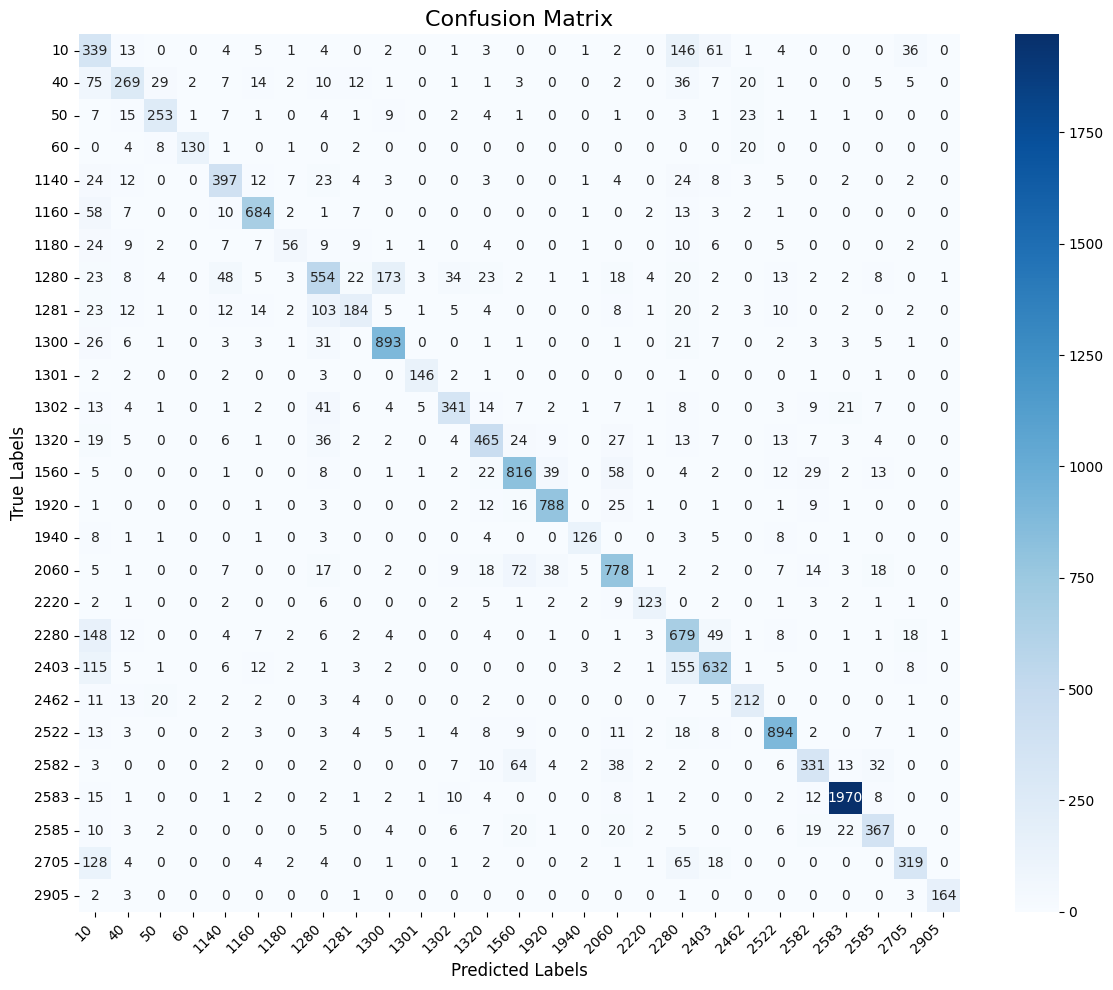

In [ ]:
# Define the class labels
class_labels = [
    "10", "40", "50", "60", "1140", "1160", "1180", "1280", "1281", "1300", "1301", "1302", "1320", "1560",
    "1920", "1940", "2060", "2220", "2280", "2403", "2462", "2522", "2582", "2583", "2585", "2705", "2905"
]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

### Relation between Class Frequency and F-1 Score

Question: Is there are relationship between class frequency (number of samples) and F-1 score?

### Relation between Class Frequency and F-1 Score

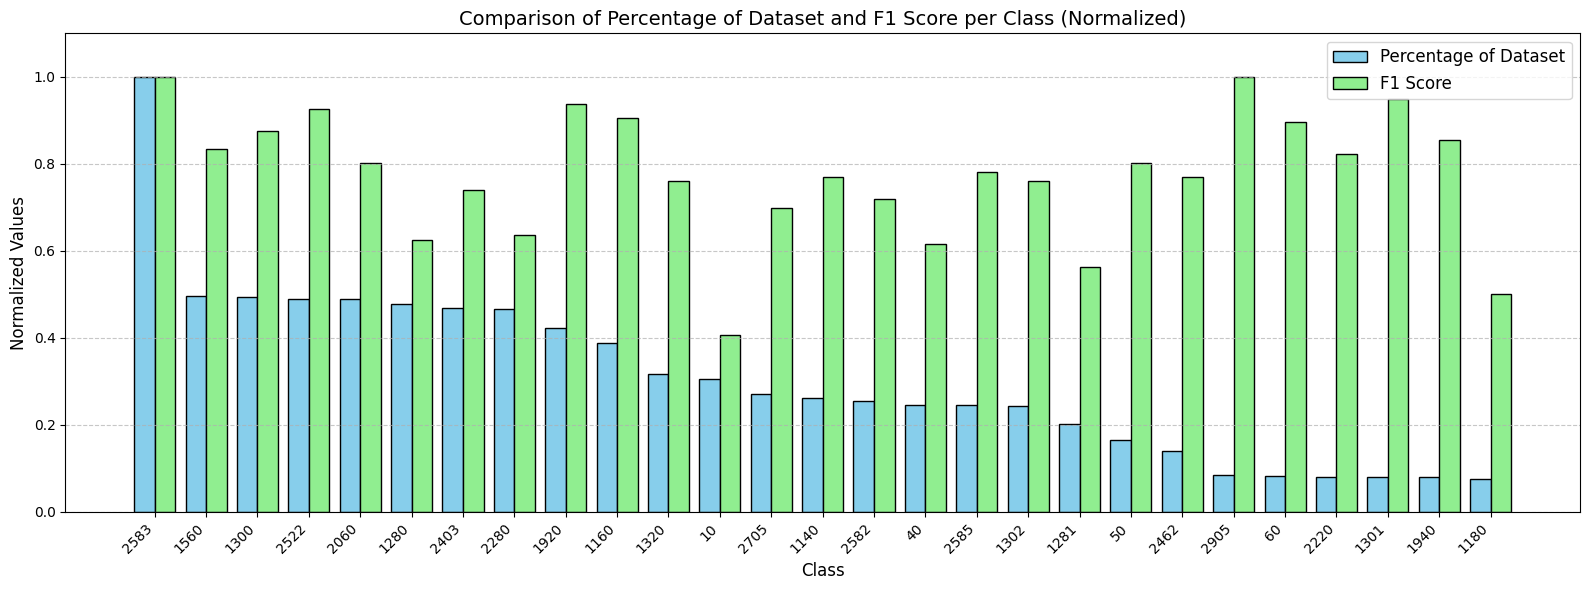

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the plot
classes = [
    "10", "40", "50", "60", "1140", "1160", "1180", "1280", "1281", "1300", "1301", "1302", "1320", "1560",
    "1920", "1940", "2060", "2220", "2280", "2403", "2462", "2522", "2582", "2583", "2585", "2705", "2905"
]
percentages = [
    3.67, 2.95, 1.98, 0.98, 3.15, 4.66, 0.90, 5.74, 2.44, 5.94, 0.95, 2.93, 3.82,
    5.97, 5.07, 0.95, 5.88, 0.97, 5.61, 5.62, 1.67, 5.88, 3.05, 12.02, 2.94, 3.25, 1.03
]
f1_scores = [
    0.39, 0.59, 0.77, 0.86, 0.74, 0.87, 0.48, 0.60, 0.54, 0.84, 0.91, 0.73, 0.73,
    0.80, 0.90, 0.82, 0.77, 0.79, 0.61, 0.71, 0.74, 0.89, 0.69, 0.96, 0.75, 0.67, 0.96
]

# Sort the data by percentages
sorted_data = sorted(zip(percentages, f1_scores, classes), reverse=True)  # Sort by percentages in descending order
percentages, f1_scores, classes = zip(*sorted_data)  # Unzip the sorted data

# Normalize the data
percentages_normalized = [p / max(percentages) for p in percentages]  # Normalize percentages to [0, 1]
f1_scores_normalized = [f / max(f1_scores) for f in f1_scores]        # F1 scores are already in [0, 1]

# Create the grouped bar chart
x = np.arange(len(classes))  # The label locations
width = 0.4  # Width of the bars

plt.figure(figsize=(16, 6))
plt.bar(x - width/2, percentages_normalized, width, label='Percentage of Dataset', color='skyblue', edgecolor='black')
plt.bar(x + width/2, f1_scores_normalized, width, label='F1 Score', color='lightgreen', edgecolor='black')

# Add labels, title, and legend
plt.title('Comparison of Percentage of Dataset and F1 Score per Class (Normalized)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Normalized Values', fontsize=12)
plt.xticks(x, classes, rotation=45, fontsize=10, ha='right')  # Rotate and align labels
plt.ylim(0, 1.1)  # Extend y-axis slightly above 1 for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

The Graph shows no clear indication of Class Frequency and F-1 score

In [ ]:
import numpy as np

# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(percentages, f1_scores)[0, 1]
print(f"Pearson Correlation Coefficient: {correlation:.2f}")

Pearson Correlation Coefficient: 0.19


The Pearson Correlation Coefficient also indicates no strong relation between Class Frequency and F-1 score

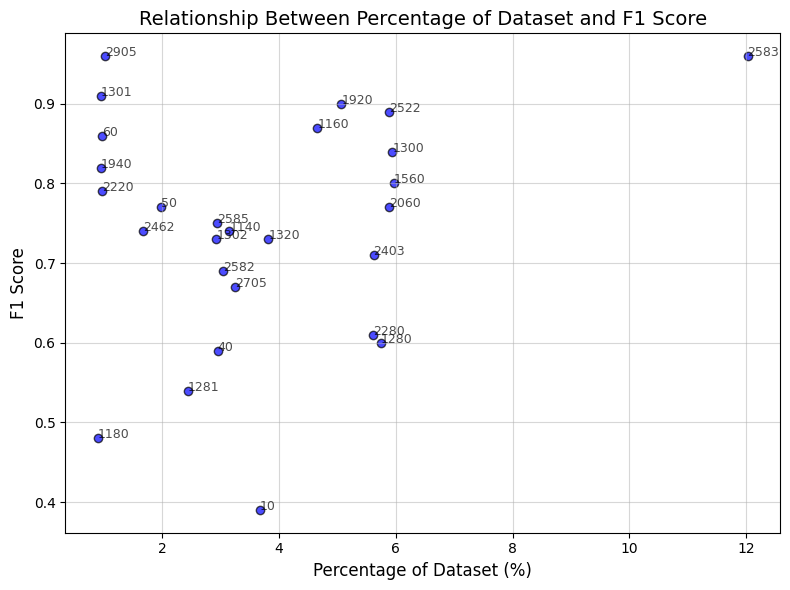

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(percentages, f1_scores, color='blue', edgecolor='black', alpha=0.7)
plt.title('Relationship Between Percentage of Dataset and F1 Score', fontsize=14)
plt.xlabel('Percentage of Dataset (%)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

# Annotate points with class labels
for i, cls in enumerate(classes):
    plt.annotate(cls, (percentages[i], f1_scores[i]), fontsize=9, alpha=0.7)

plt.show()

Finally the Graphic above also indicates that there is no direct relation between F-1 score and class frequency. It is therefore safe to consider the two metrics not to be linearly related. The ML amgorithm (SVM) is better at detecting some of the categories with a smaller sample size.